# Автоэнкодер на CIFAR10

In [1]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
train_dataset = datasets.CIFAR10(download=True, root="/data", train=True, transform=ToTensor())

100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s]


Вычислим среднее и стандартное отклонение, чтобы нормализовать изображения по каналам

In [4]:
def mean_std(dataset):
    channels_sum = torch.zeros(3)
    channels_sq_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in dataset:
        channels_sum += images.sum(dim=[1, 2])  # cумма по каналам
        channels_sq_sum += (images**2).sum(dim=[1, 2])  # сумма квадратов
        num_pixels += images.shape[1] * images.shape[2]  # кол-во пикселей

    mean = channels_sum / num_pixels
    std = (channels_sq_sum / num_pixels - mean**2)**0.5

    return mean, std

mean, std = mean_std(train_dataset)
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [5]:
from torch.utils.data import random_split

transform_norm = Compose((
    ToTensor(),
    Normalize(mean, std)
))

train_dataset.transform = transform_norm
test_dataset = datasets.CIFAR10(download=True, root="/data", train=False, transform=transform_norm)

train_dataset, valid_dataset = random_split(train_dataset, (0.8, 0.2))

mean_std(train_dataset)

(tensor([-2.6321e-04, -6.9241e-06, -9.9606e-04]),
 tensor([0.9995, 0.9993, 0.9990]))

In [6]:
mean_std(test_dataset)

(tensor([0.0114, 0.0122, 0.0148]), tensor([0.9985, 0.9976, 1.0000]))

на тестовой распределение похоже на тренировочную

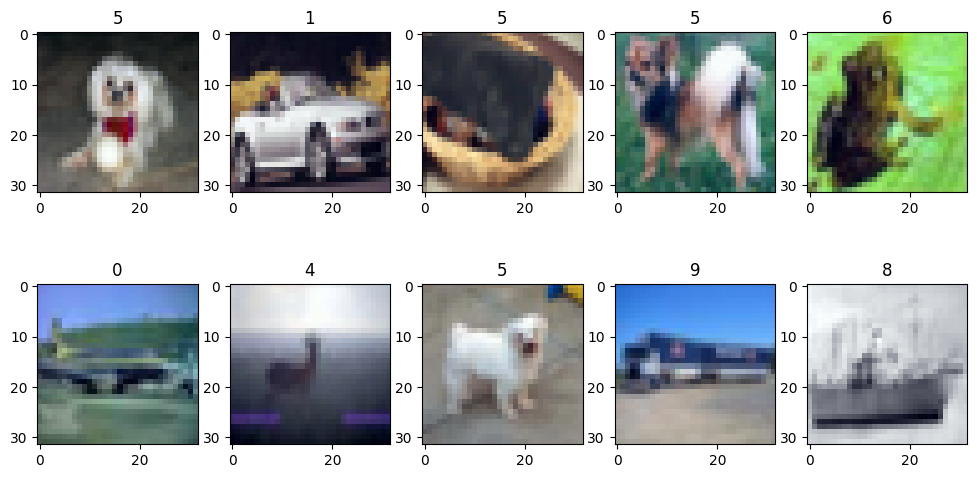

In [10]:
plt.figure(figsize=(12, 6))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    photo = train_dataset[i][0].permute(1, 2, 0)
    photo = (photo - photo.min())/(photo.max() - photo.min())
    plt.imshow(photo)
    plt.title(train_dataset[i][1])

for i in range(5):   # валидационные фотки
    plt.subplot(2, 5, i + 6)
    photo = valid_dataset[i][0].permute(1, 2, 0)
    photo = (photo - photo.min())/(photo.max() - photo.min())
    plt.imshow(photo)
    plt.title(valid_dataset[i][1])

plt.show()

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)

**Обучение**

In [13]:
from torch import nn

class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten(-3)
        self.coder = nn.Sequential(
            nn.Linear(32*32*3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )

    def forward(self, x):
        x = self.flat(x)
        return self.coder(x)

class autoencoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encode = encoder
        self.decode = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1024*3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x

In [14]:
from torchsummary import summary

encoder_v1 = encoder().to(device)
autoencoder_v1 = autoencoder(encoder_v1).to(device)

summary(encoder_v1, (32, 32, 3)), summary(autoencoder_v1, (32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 16]           1,040
Total params: 201,872
Trainable params: 201,872
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.77
Estimated Total Size (MB): 0.81
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1,

(None, None)

In [15]:
from torch import optim

loss_func = nn.MSELoss()
optimizator = optim.Adam(autoencoder_v1.parameters(), lr=0.001)

def train(model, dataload, dataload_valid, optimizator, loss_func=nn.MSELoss()):
    model.train()
    sumloss = 0
    for data, _ in dataload:
        data = data.to(device)

        pred = model(data)
        loss = loss_func(torch.flatten(data, -3), pred)
        sumloss += loss.item()

        loss.backward()
        optimizator.step()
        optimizator.zero_grad()

    model.eval()
    sum_loss_val = 0
    with torch.no_grad():
        for data, _ in dataload_valid:
            data = data.to(device)
            pred = model(data)
            loss = loss_func(torch.flatten(data, -3), pred)
            sum_loss_val += loss.item()

    return sumloss / len(dataload), sum_loss_val / len(dataload_valid)

In [85]:
def full_train(model, epochs, optimizator, loss_function=nn.MSELoss()):
    random = torch.randperm(len(train_dataset))[:6]
    data = [train_dataset[i][0].to(device) for i in random]
    data_cpu = torch.stack(data).cpu()
    data_cuda = data_cpu.to(device)

    def show_5img(data, normilized=True):
        data = data.to("cpu")
        plt.figure(figsize=(12, 4))
        for i in range(0, 6):
            plt.subplot(1, 6, i + 1)
            photo = data[i].permute(1, 2, 0)
            if normilized:
                photo = (photo - photo.min())/(photo.max() - photo.min())
            plt.imshow(photo)
        plt.show()

    show_5img(data_cpu)

    for epoch in range(1, epochs + 1):
        loss, val_loss = train(model, train_dataloader, valid_dataloader, optimizator, loss_function)
        print(epoch, "эпоха:", loss, val_loss)

        inference = model(data_cuda)

        if not torch.is_tensor(inference):
            inference = inference[0]

        autoencoded = inference.detach()


        show_5img(autoencoded.reshape(6, 3, 32, 32), False)

    show_5img(data_cpu)

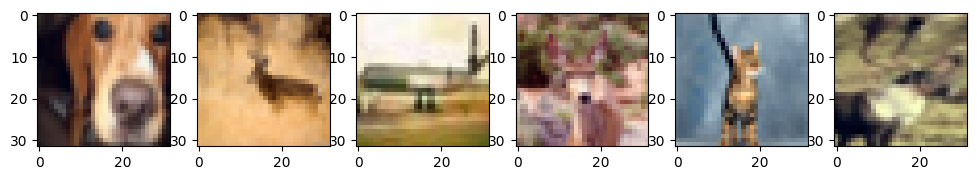

1 эпоха: 0.7321651280879974 0.6874161900613255


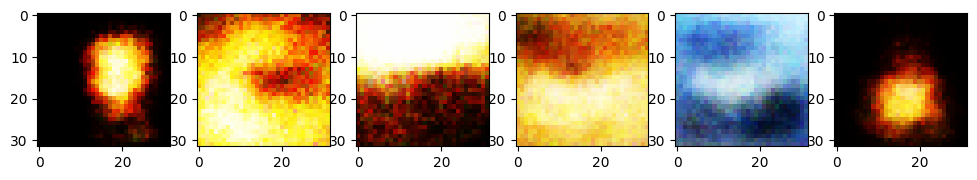

2 эпоха: 0.6737077642202377 0.6710665618268826


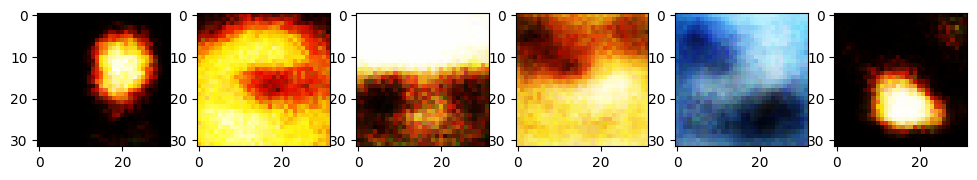

3 эпоха: 0.6629543717622757 0.6642231810778475


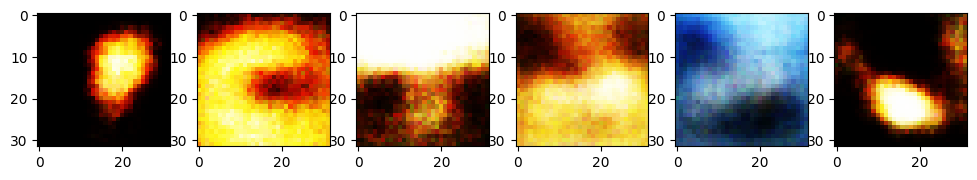

4 эпоха: 0.6566346529722213 0.6574864216125049


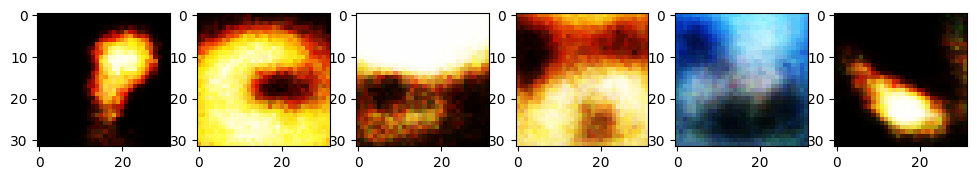

5 эпоха: 0.6499773686408996 0.6519593321286832


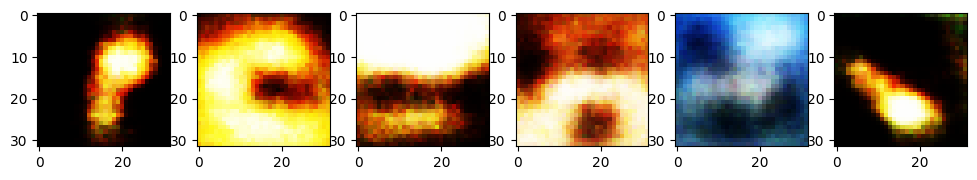

6 эпоха: 0.646531669831276 0.6501491912447226


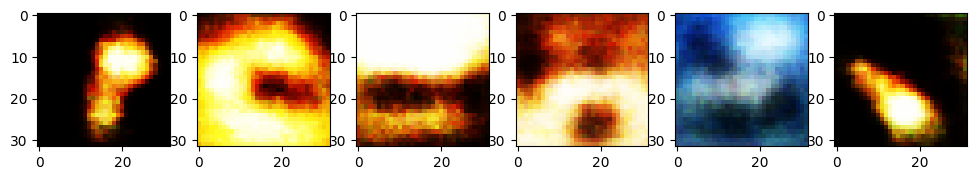

7 эпоха: 0.6448497621297836 0.6490395750862341


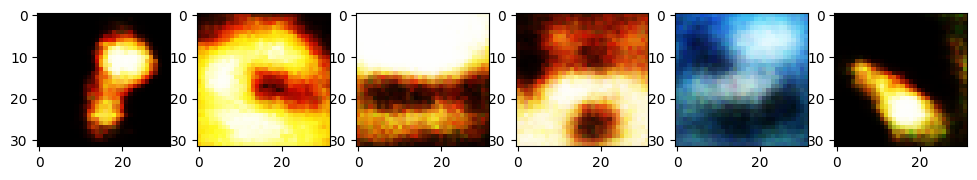

8 эпоха: 0.6434525632143021 0.6478478457219303


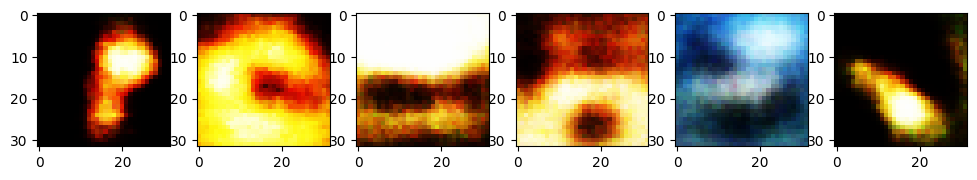

9 эпоха: 0.6422224323749542 0.6474577696940389


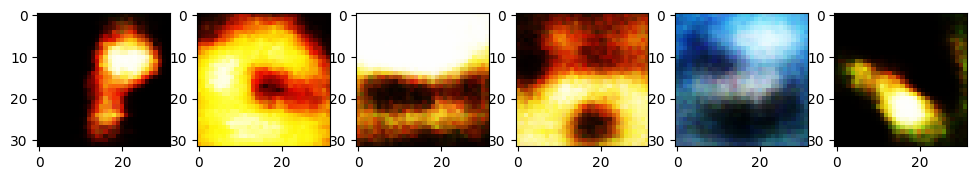

10 эпоха: 0.6412947606801986 0.6471062097876978


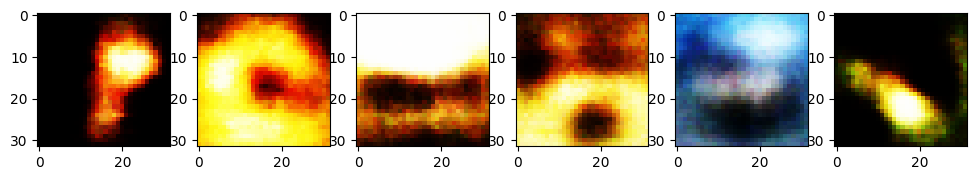

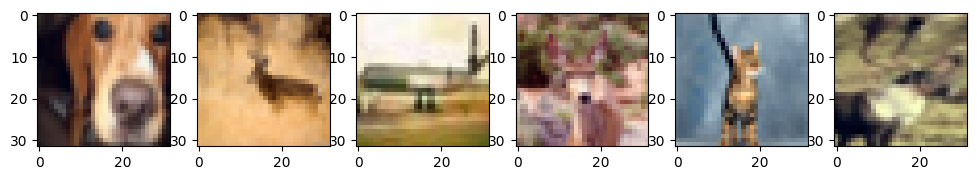

In [17]:
full_train(autoencoder_v1, 10, optimizator)

После 10 эпох сеть уже вышла на плато по лоссу, так что особого смысла обучать еще нет. Если посмотреть то сеть смогла научиться улавливать цвета областей, но довольно не качественно

**Попробуем изменить, использовав свертки для кодировки**

In [ ]:
from torch import nn

class conv_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten(-3)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.ReLU()
        )
        self.coder = nn.Linear(13 * 13 * 8, 64)

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        return self.coder(x)

class conv_autoencoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encode = encoder
        self.decode = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1024*3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x

In [ ]:
encoder_v2 = conv_encoder().to(device)
autoencoder_v2 = conv_autoencoder(encoder_v2).to(device)

summary(encoder_v2, (3, 32, 32)), summary(autoencoder_v2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4            [-1, 8, 13, 13]           1,160
              ReLU-5            [-1, 8, 13, 13]               0
           Flatten-6                 [-1, 1352]               0
            Linear-7                   [-1, 64]          86,592
Total params: 88,200
Trainable params: 88,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 0.34
Estimated Total Size (MB): 0.63
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

(None, None)

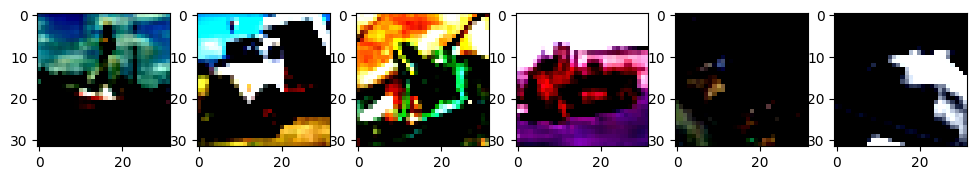

1 эпоха: 0.7096214644908905 0.647219180965576


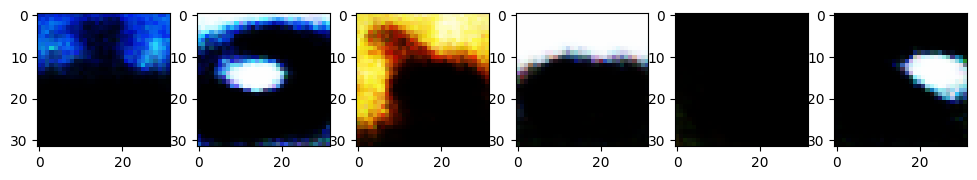

2 эпоха: 0.6403172956228256 0.6260356856420779


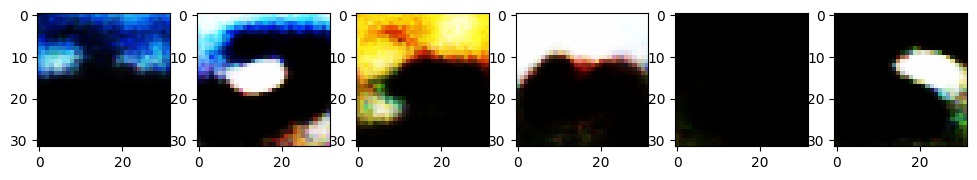

3 эпоха: 0.6251557690382004 0.6148110770950683


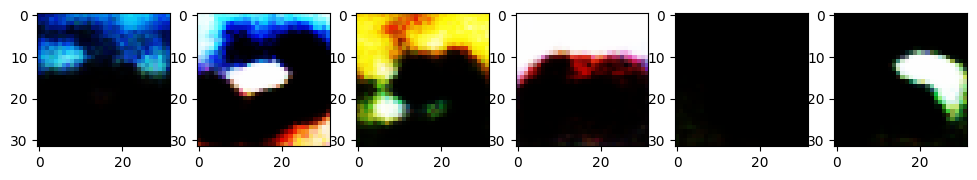

4 эпоха: 0.6164250909805298 0.6088789893796269


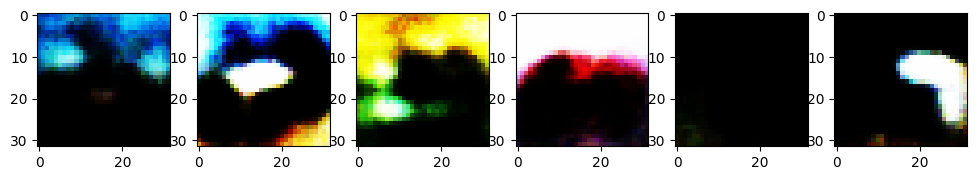

5 эпоха: 0.6106026168346405 0.6037869993299722


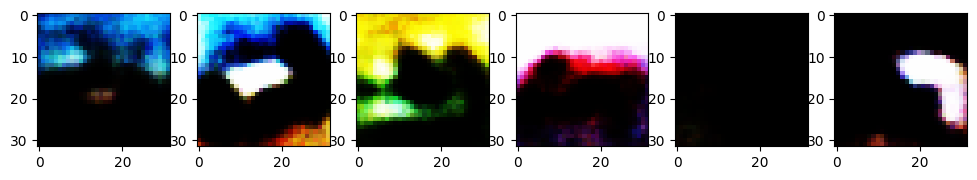

6 эпоха: 0.6066300047874451 0.6007935877044361


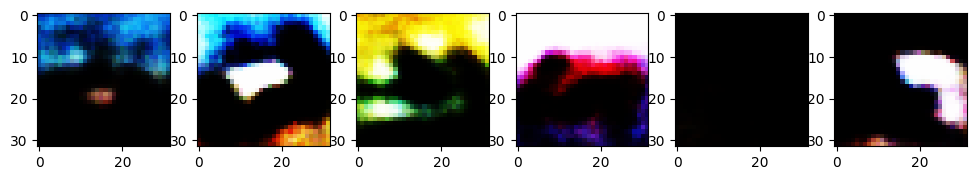

7 эпоха: 0.6033983732938767 0.5979471912208837


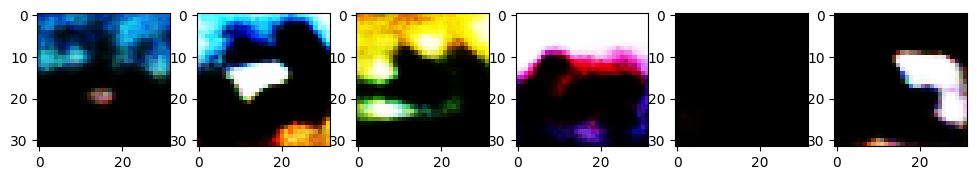

8 эпоха: 0.6007661278009415 0.5963663950134009


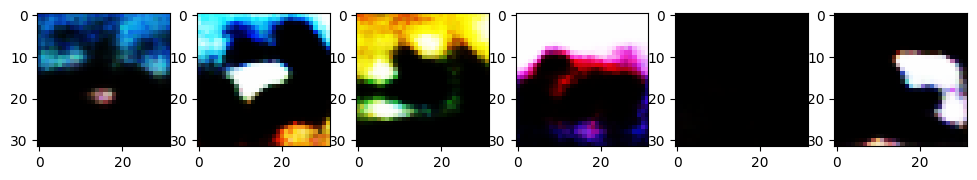

9 эпоха: 0.5987671544313431 0.595412130173022


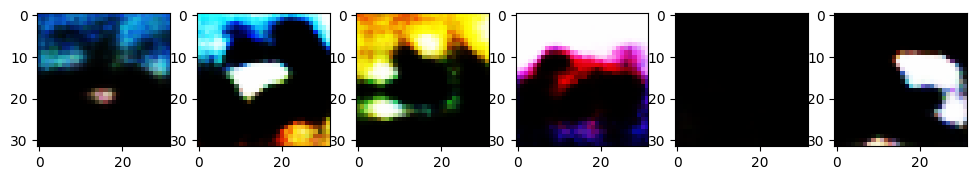

10 эпоха: 0.5969598606824875 0.593176400033049


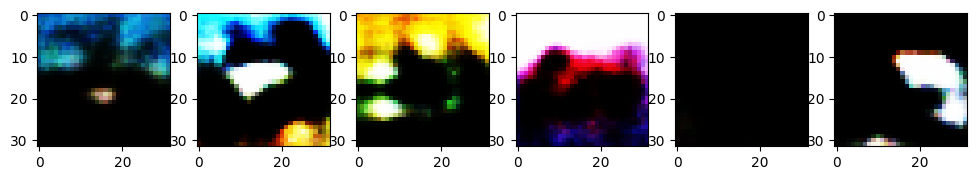

11 эпоха: 0.5952125703334809 0.5911587240596929


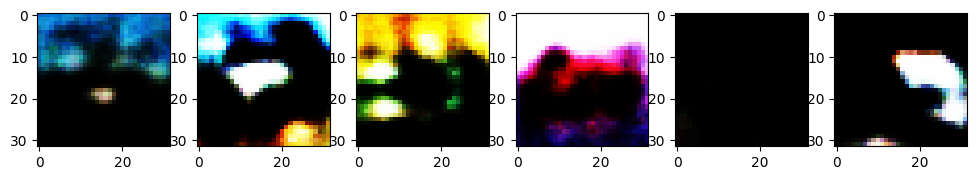

12 эпоха: 0.5937151149272919 0.5895426864631641


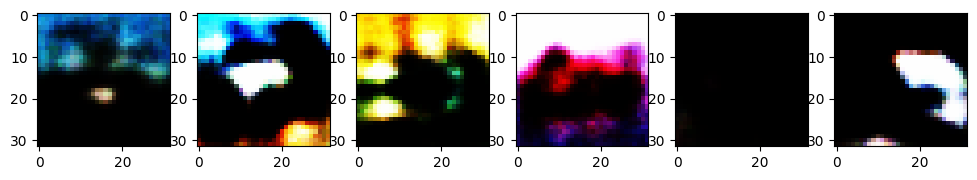

13 эпоха: 0.5924289059877396 0.5884406342864418


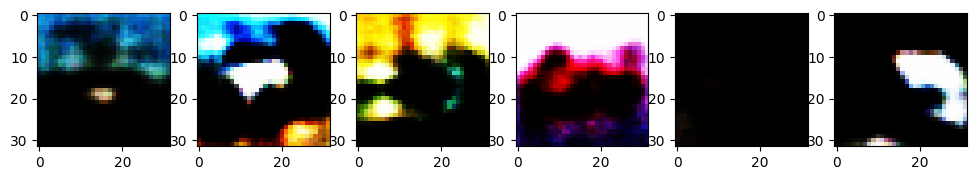

14 эпоха: 0.5913165626049042 0.5874195256933998


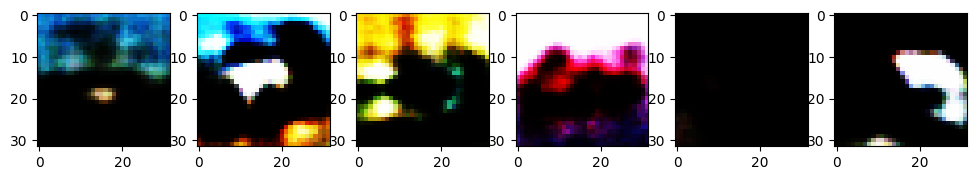

15 эпоха: 0.5901527942419053 0.5864162317480142


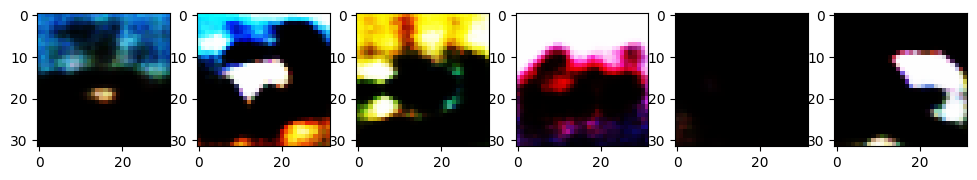

16 эпоха: 0.5890831940889358 0.5854930312107927


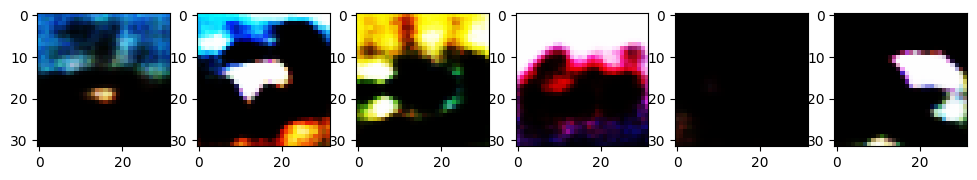

17 эпоха: 0.5882733200788498 0.5845406183038657


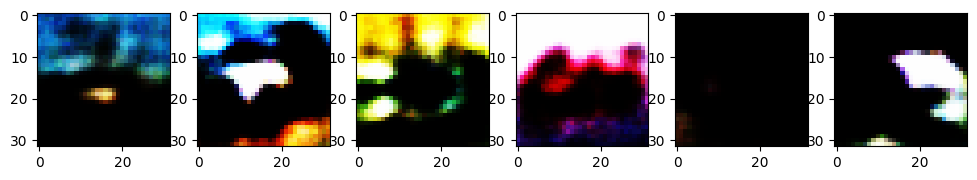

18 эпоха: 0.5876010667562485 0.5841339620919274


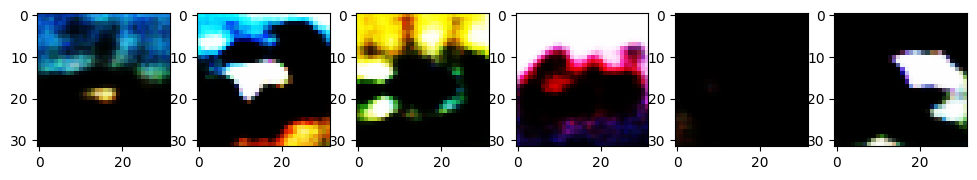

19 эпоха: 0.586892862200737 0.5835676077074898


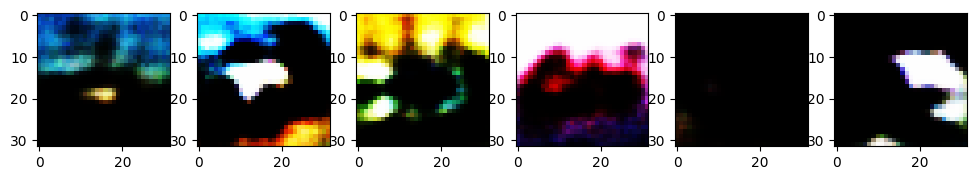

20 эпоха: 0.5862321676969529 0.5830103204654048


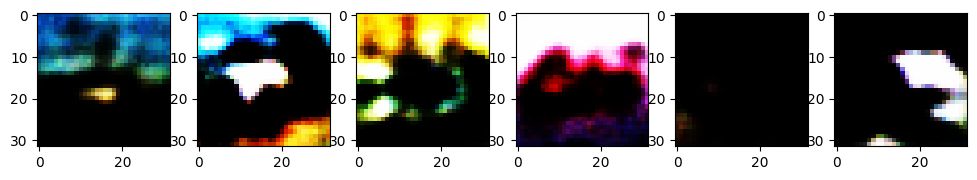

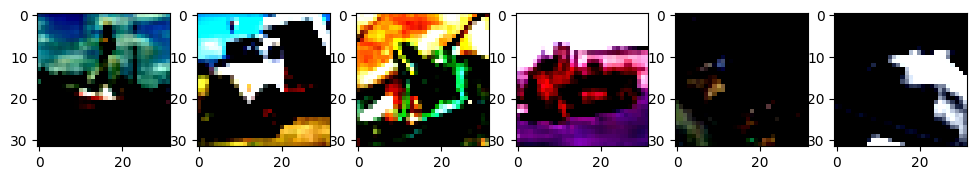

In [ ]:
optimizator = optim.Adam(autoencoder_v2.parameters(), lr=0.001)

full_train(autoencoder_v2, 20, optimizator)

**Получачется уже лучше, но возможно получиться улучшить качество сделав автоэнкодер симметричней и избавившись от линейных слоев тк они сжимают все каналы и размерность. Используем обратные свертки, чтобы изменить декодер, из кодировщика просто уберем линейный слой**

In [ ]:
class conv_encoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class convTrans_autoencoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encode = encoder
        self.decode_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, dim1=True):
        start = x
        x = self.encode(x)
        x = self.decode_conv(x)
        #x += start
        if dim1:     # тк в функции обучения для остальных модель все сводилось к 1д тензору при вычислении лосса
            x = torch.flatten(x, -3)

        return x

In [ ]:
encoder_v2 = conv_encoder2().to(device)
autoencoder_v3 = convTrans_autoencoder(encoder_v2).to(device)

summary(encoder_v2, (3, 32, 32)), summary(autoencoder_v3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,320
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
Total params: 2,768
Trainable params: 2,768
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.35
Params size (MB): 0.01
Estimated Total Size (MB): 0.37
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 3

(None, None)

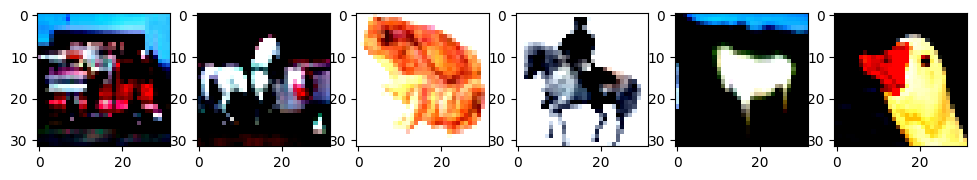

1 эпоха: 0.6109431553840637 0.564803087482818


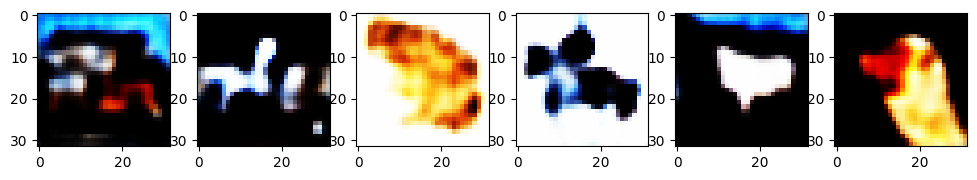

2 эпоха: 0.5669769685268402 0.559456331661334


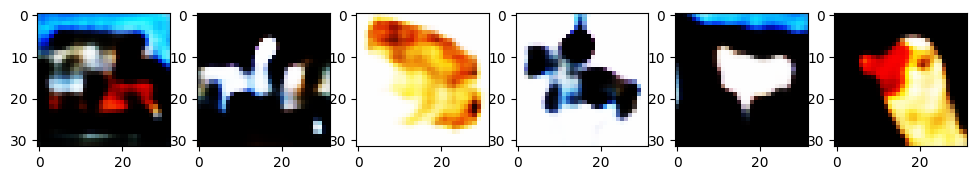

3 эпоха: 0.5612713072299957 0.5537594972898404


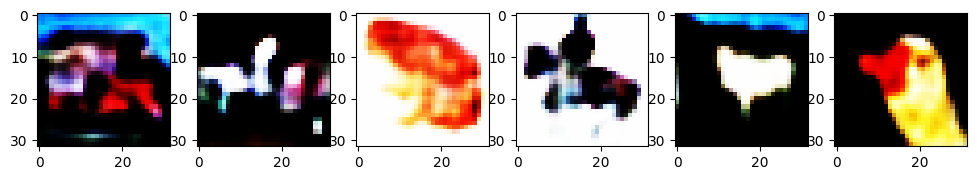

4 эпоха: 0.5582879398107529 0.5519589926488102


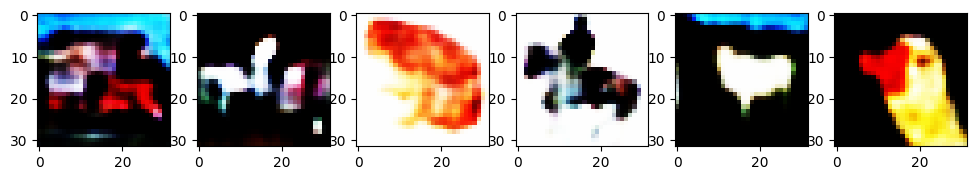

5 эпоха: 0.55660605905056 0.550520089487679


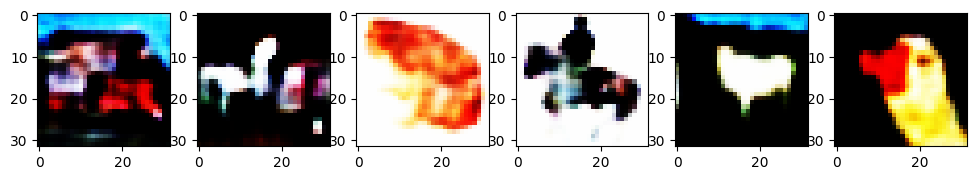

6 эпоха: 0.5553452463150025 0.5494171758048451


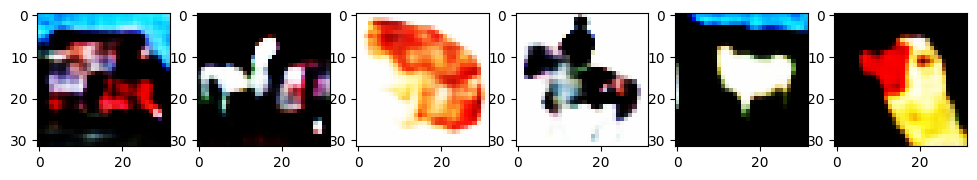

7 эпоха: 0.5543636363744736 0.5485479702203038


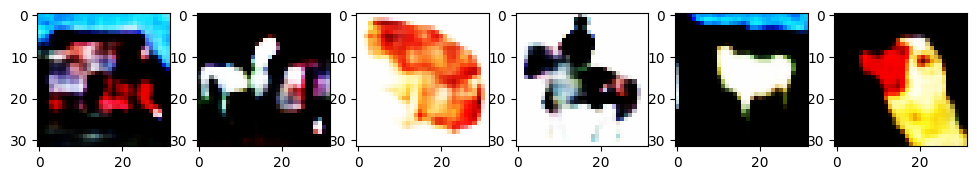

8 эпоха: 0.5536263165712356 0.5478594861091516


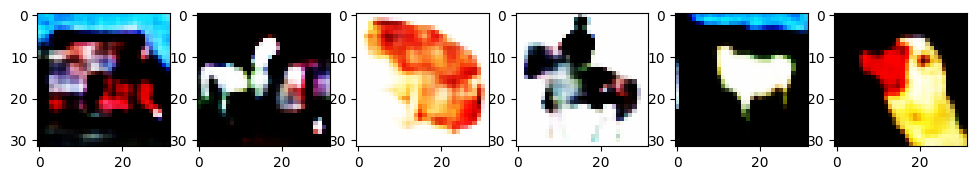

9 эпоха: 0.5530684789419175 0.5473585391577821


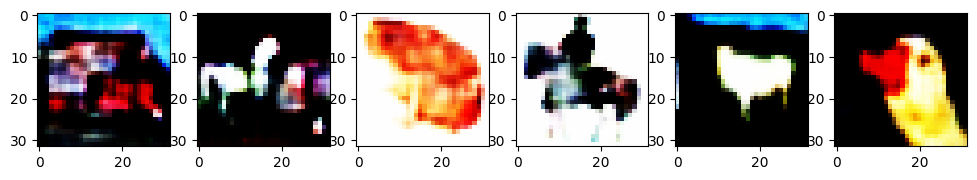

10 эпоха: 0.5526499994754791 0.5470089797204295


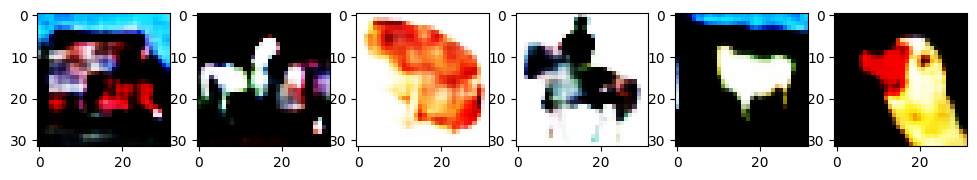

11 эпоха: 0.5523316386461258 0.5467356033028125


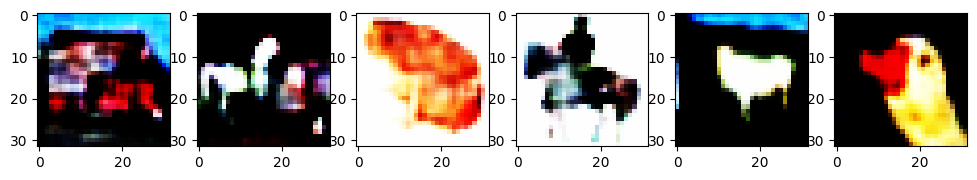

12 эпоха: 0.5520768736839294 0.5465216008238137


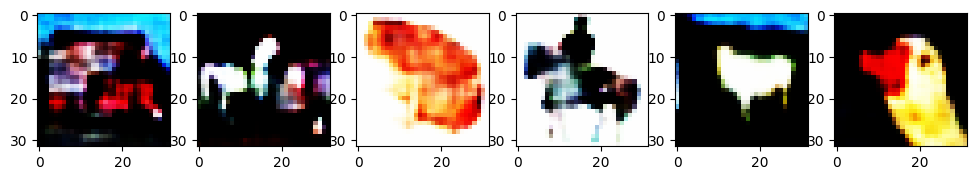

13 эпоха: 0.5518646337747574 0.5463278090801483


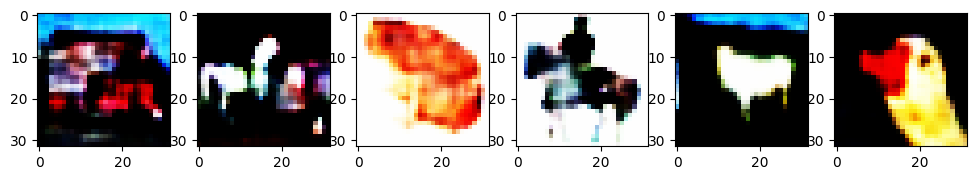

14 эпоха: 0.5516807881116867 0.5461579253688787


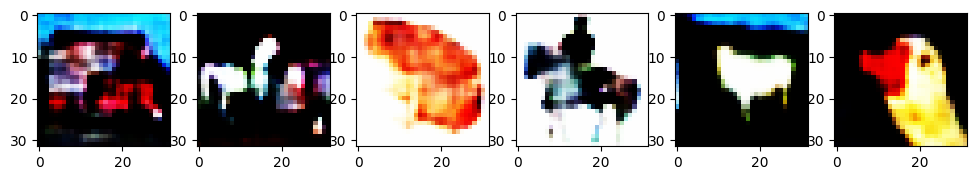

15 эпоха: 0.5515195798158645 0.5460310842092044


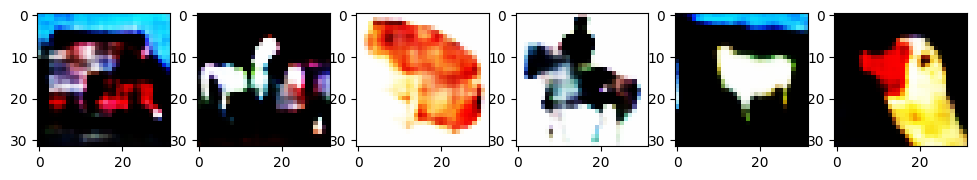

16 эпоха: 0.5513752744674683 0.5459045234579629


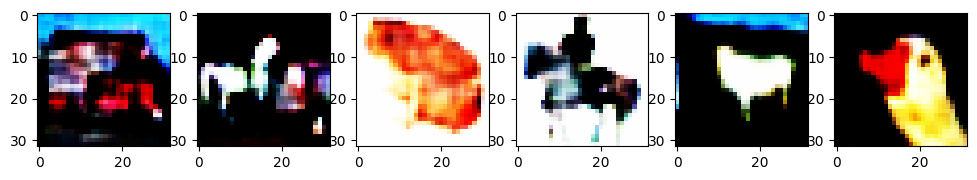

17 эпоха: 0.5512398748397828 0.5457755205349419


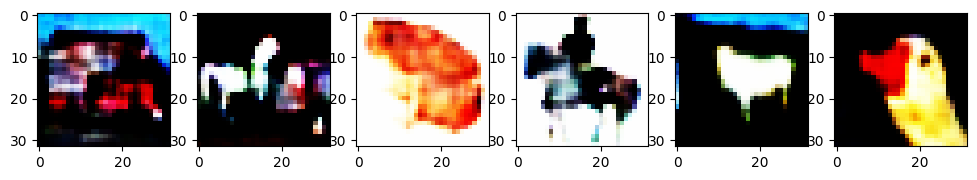

18 эпоха: 0.5511125359773635 0.5456492819915564


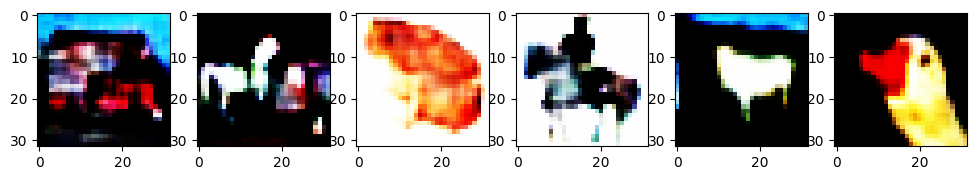

19 эпоха: 0.550992954492569 0.5455506019318066


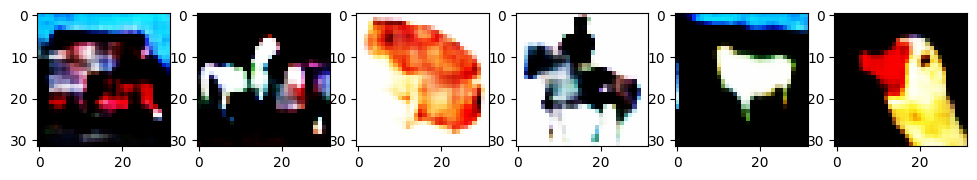

20 эпоха: 0.5508804411411286 0.5454301139036306


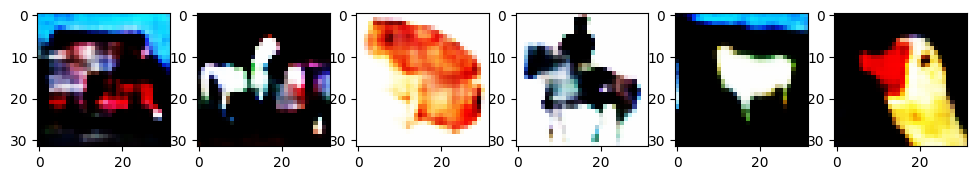

21 эпоха: 0.5507739105463028 0.5453213532321369


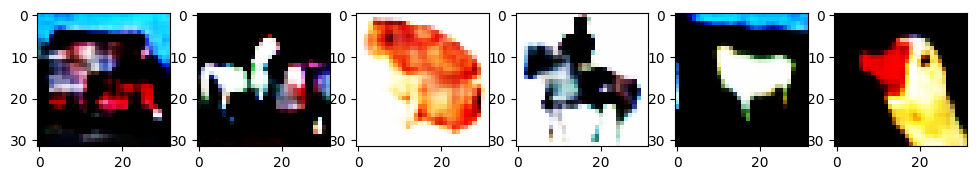

22 эпоха: 0.55067372443676 0.545223375002797


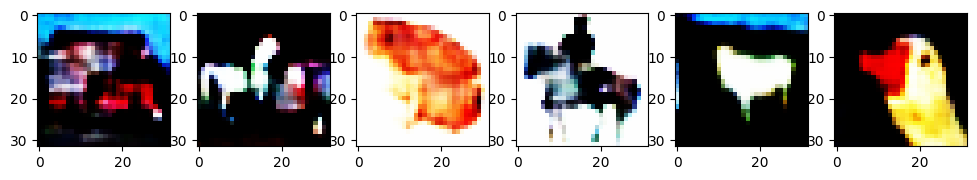

23 эпоха: 0.5505795747518539 0.5451368503867627


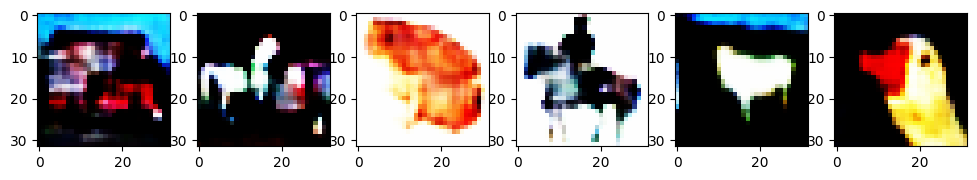

24 эпоха: 0.5504917640924454 0.5450517556156975


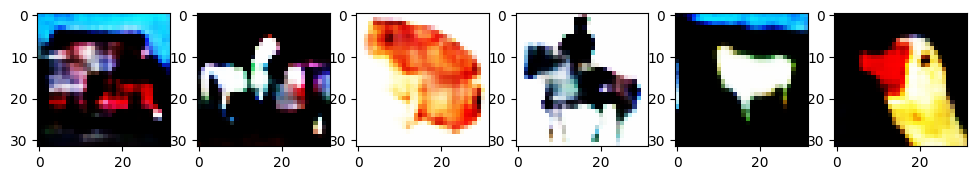

25 эпоха: 0.5504113387584686 0.5449893120378732


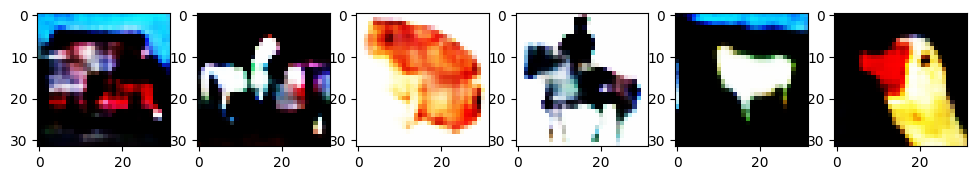

26 эпоха: 0.5503374988794327 0.5449168935370522


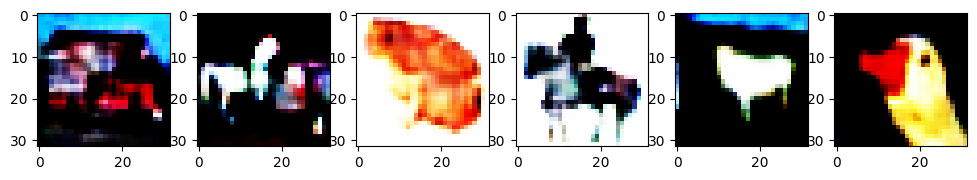

27 эпоха: 0.5502715346813202 0.544860082502944


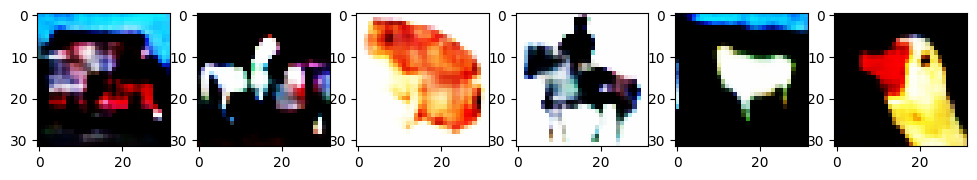

28 эпоха: 0.5502099925518036 0.5447997249924718


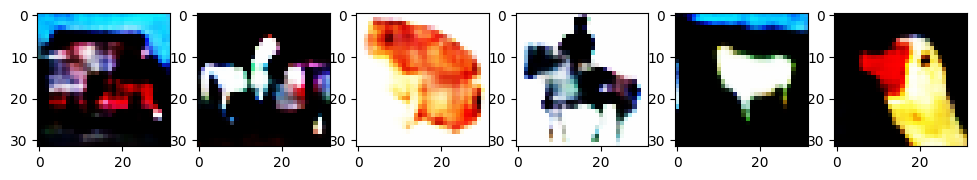

29 эпоха: 0.550151820397377 0.5447503298806687


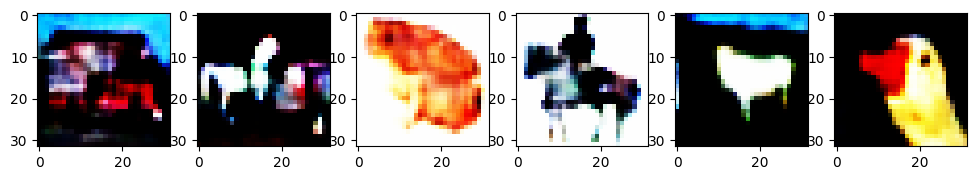

30 эпоха: 0.5501004048109055 0.5447054737673019


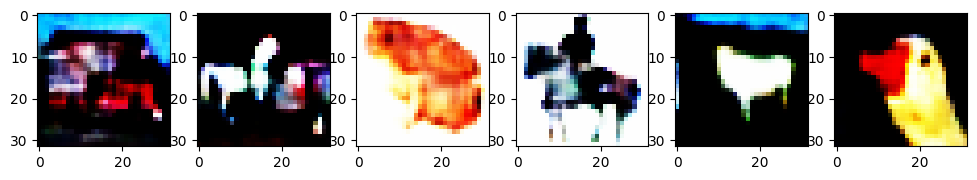

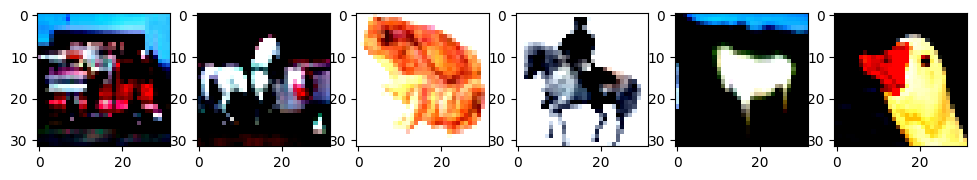

In [ ]:
optimizator = optim.Adam(autoencoder_v3.parameters(), lr=0.001)

full_train(autoencoder_v3, 30, optimizator)

**Данный автоэнкодер уже совсем неплохо справляется**

# Вариационный автоэнкодер

In [21]:
class VariationalAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(-3)
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )

        self.mu = nn.Linear(256, 128)
        self.var = nn.Linear(256, 128)

        self.first_decode = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 32*32*3),
            nn.BatchNorm1d(32*32*3),
            nn.Sigmoid()
        )

    def reparameter(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, x):
        x = self.flatten(x)
        h = self.encoder(x)
        mu = self.mu(h)
        var = self.var(h)

        z = self.reparameter(mu, var)

        res = self.first_decode(z)
        res += h
        res = self.decoder(res)
        return res, mu, var

In [22]:
vae_v1 = VariationalAE().to(device)

summary(vae_v1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
       BatchNorm1d-3                  [-1, 256]             512
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
            Linear-6                  [-1, 128]          32,896
            Linear-7                  [-1, 256]          33,024
       BatchNorm1d-8                  [-1, 256]             512
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                 [-1, 3072]         789,504
      BatchNorm1d-11                 [-1, 3072]           6,144
          Sigmoid-12                 [-1, 3072]               0
Total params: 1,682,176
Trainable params: 1,682,176
Non-trainable params: 0
---------------------------

In [81]:
def loss_function(x, pred):
    pred, mu, var = pred
    loss = nn.MSELoss()
    MSE = loss(x, pred)
    KL = -0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())

    if not hasattr(loss_function, "a"):
        loss_function.a = 0.5
    else:
        loss_function.a *= 0.8

    return MSE + loss_function.a * KL

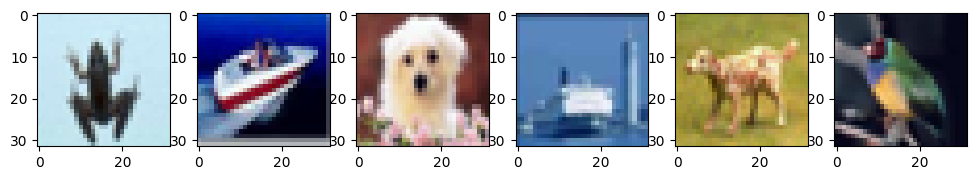

1 эпоха: 0.7299715515613556 0.686021344158977


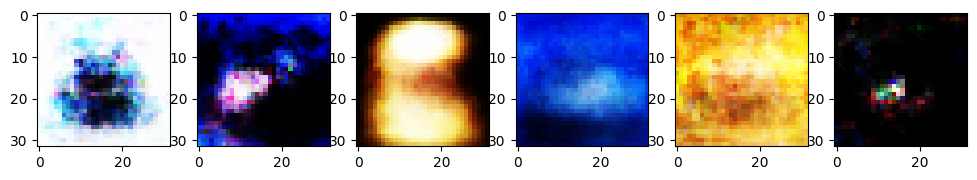

2 эпоха: 0.6911643548488617 0.6773709293942862


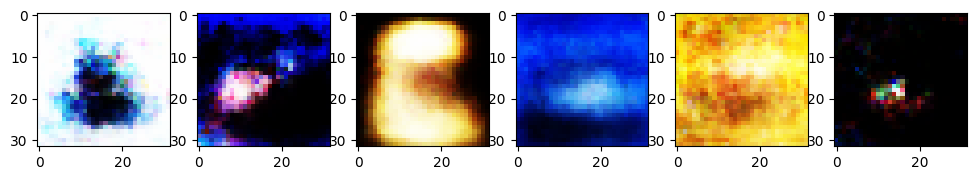

3 эпоха: 0.6798690368652344 0.6656409491555759


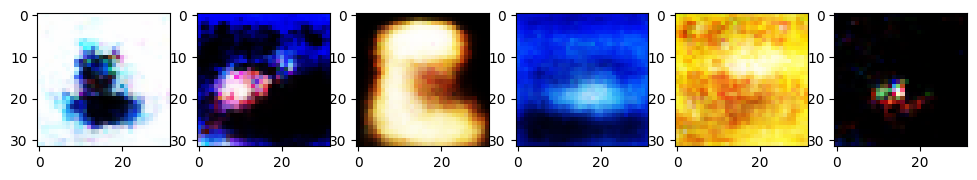

4 эпоха: 0.6711137513160705 0.6563308241839607


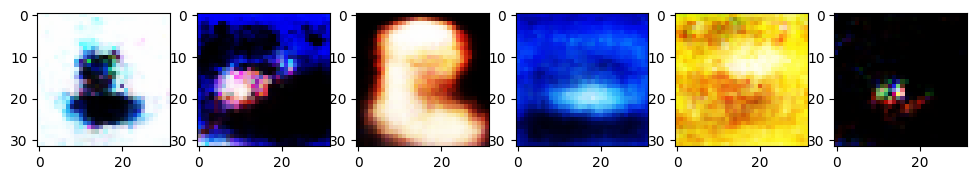

5 эпоха: 0.6628769913434982 0.6488508140317167


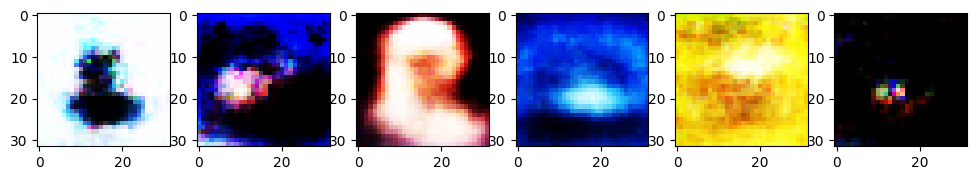

6 эпоха: 0.6563419228792191 0.6423555923917423


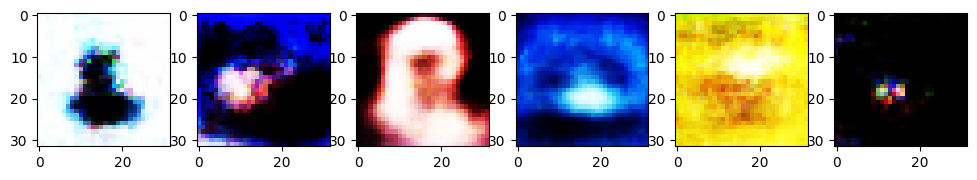

7 эпоха: 0.6498538392782212 0.6364956044922241


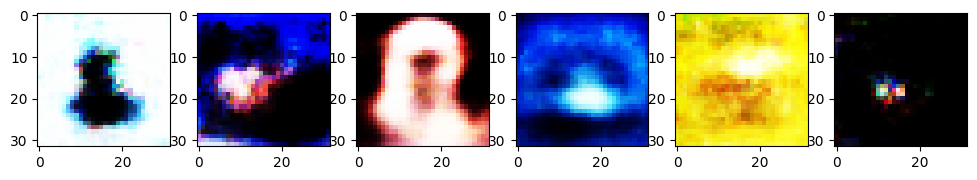

8 эпоха: 0.643971393251419 0.6310048176648136


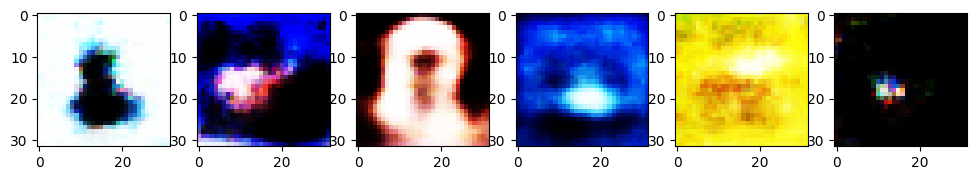

9 эпоха: 0.6380266353368759 0.6243840404592764


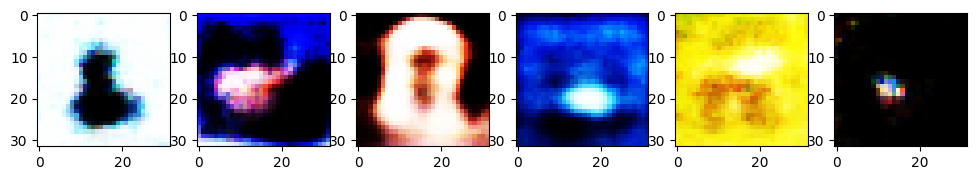

10 эпоха: 0.6314267342805863 0.6182592532124382


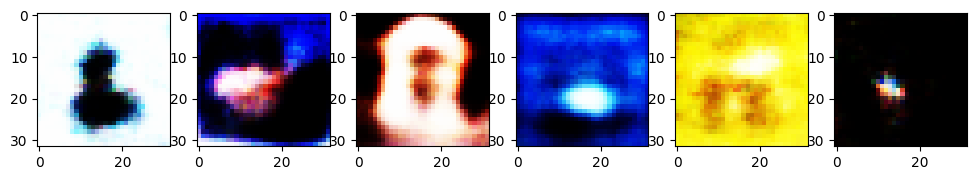

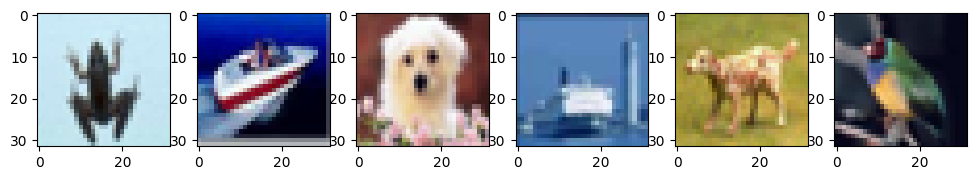

In [24]:
optimizator = optim.Adam(vae_v1.parameters(), lr=0.001)
full_train(vae_v1, 10, optimizator, loss_function)

In [86]:
class VariationalAE_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.encoder_block2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.encoder_block3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flat = nn.Flatten(-3)
        # self.mu = nn.Conv2d(8, 8, 3, padding=1)
        # self.var = nn.Conv2d(8, 8, 3, padding=1)
        self.mu = nn.Linear(128, 128)
        self.var = nn.Linear(128, 128)
        self.unflat = nn.Unflatten(1, (8, 4, 4))

        self.decoder_block1 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.decoder_block2 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.decoder_block3 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def reparameter(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, x, dim1=True):
        code1 = self.encoder_block1(x)
        code2 = self.encoder_block2(code1)
        code3 = self.encoder_block3(code2)
        mu = self.mu(self.flat(code3))
        var = self.var(self.flat(code3))

        z = self.reparameter(mu, var)

        z = self.unflat(z)
        res = self.decoder_block1(z)
        res = res + code2
        res = self.decoder_block2(res)
        res = res + code1
        res = self.decoder_block3(res)

        if dim1:
            res = torch.flatten(res, -3)
        return res, mu, var

In [87]:
vae_v2 = VariationalAE_conv().to(device)

summary(vae_v2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
         MaxPool2d-8             [-1, 16, 8, 8]               0
            Conv2d-9              [-1, 8, 8, 8]           1,160
      BatchNorm2d-10              [-1, 8, 8, 8]              16
             ReLU-11              [-1, 8, 8, 8]               0
        MaxPool2d-12              [-1, 8, 4, 4]               0
          Flatten-13                  [-1, 128]               0
           Linear-14                  [

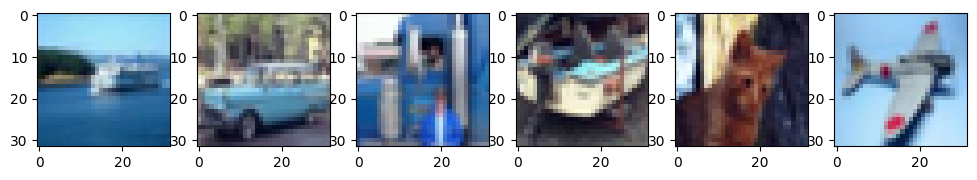

1 эпоха: 0.5687094171524048 0.5486459989136401


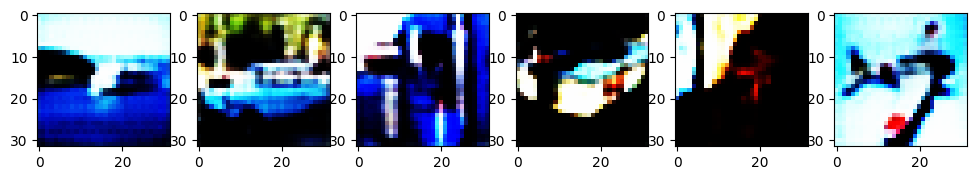

2 эпоха: 0.545344791507721 0.5470199822998656


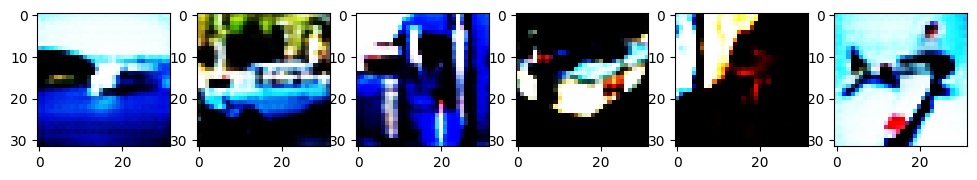

3 эпоха: 0.5440861497879028 0.5462914089234873


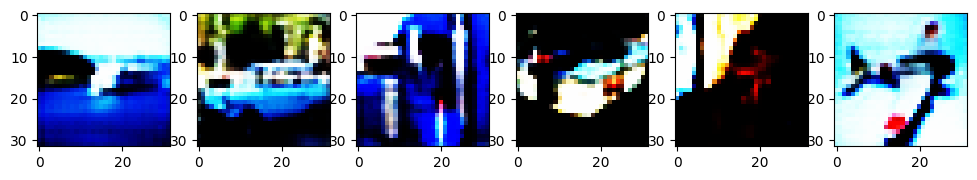

4 эпоха: 0.5434188723802567 0.5455671782120348


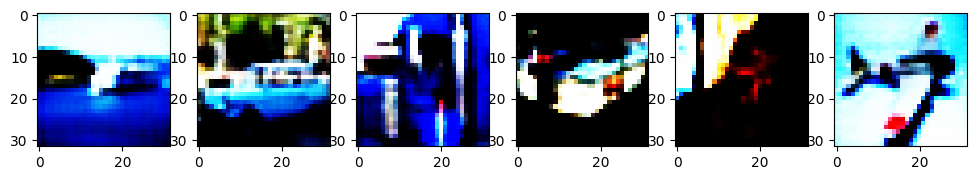

5 эпоха: 0.5429249855279923 0.5454339320286394


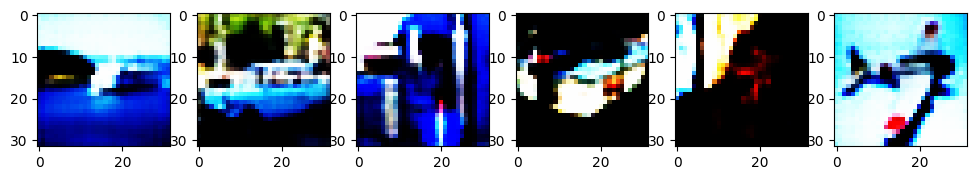

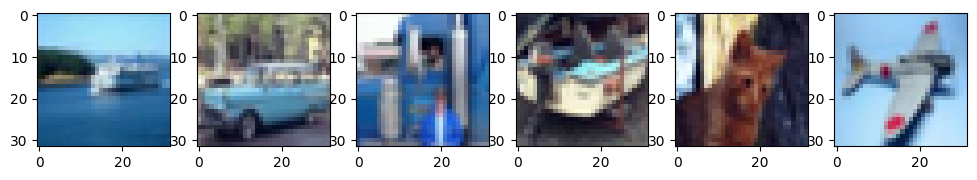

In [88]:
torch.autograd.set_detect_anomaly(True)
optimizator = optim.Adam(vae_v2.parameters(), lr=0.001)
full_train(vae_v2, 5, optimizator, loss_function)